In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
#train_frame = train_frame.iloc[-1:]
test_frame = pd.read_pickle("../../data/test_data.pkl")

In [3]:
class TraceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = torch.tensor(train_frame.iloc[idx]['input'], dtype=torch.float32)
        target = torch.tensor(train_frame.iloc[idx]['target'], dtype=torch.float32)
        return input, target

train_dataset = TraceDataset(train_frame)
test_dataset = TraceDataset(test_frame)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [15]:
def bicycle_model_eval(input, last_pose):
    # This version takes in an input of dim 5
    trace = []#torch.zeros((80, 3))
    states = []#torch.zeros((80, 5))
    start_v = input[0]
    trace.append(last_pose.clone().detach().requires_grad_(True))
    L = 0.3302
    TS = 0.1
    X, Y, THETA = 0, 1, 2
    dX, dY, dTHETA, dV, V = 0, 1, 2, 3, 4
    #states[0, 0:3] = input[0:3]
    #states[0, V] = input[3]
    states.append(torch.tensor([0,0,0,input[2],input[0]]))
    for i in range(1,81):
        # Advance bicycle model
        states.append([states[-1][V] * torch.cos(trace[-1][THETA]),
                       states[-1][V] * torch.sin(trace[-1][THETA]),
                       (states[-1][V] * torch.tan(input[1])) / L,
                       input[2],
                       states[i-1][V] + TS*input[2]])
        #states[i, dX] = states[i-1,V] * torch.cos(trace[i-1,THETA])
        #states[i, dY] = states[i-1,V] * torch.sin(trace[i-1,THETA])
        #states[i, dTHETA] = (states[i-1,V] * torch.tan(input[4])) / L
        #states[i, dV] = input[5]
        #states[i, V] = states[i-1, V] + TS*states[i, dV]
        trace.append(trace[-1] + TS*torch.tensor(states[-1][0:3], dtype=torch.float32))
    trace.pop(0)
    return torch.vstack(trace)

def custom_loss_func(prediction, target, output):
    loss = F.mse_loss(prediction, target)
    loss += 10*output[0] if output[0]<0 else 0
    loss += 2*torch.linalg.norm(output)**2
    return loss

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=10, target_size=3):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, target_size)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        return output

In [16]:
net = LSTMPredictor()
net.load_state_dict(torch.load("best_simple_bicycle.pt"))

<All keys matched successfully>

In [17]:
torch.tensor(train_frame.iloc[0]['input'])

tensor([[-58.9267,  31.1195,   2.0114],
        [-59.0875,  31.4569,   2.0265],
        [-59.2471,  31.7847,   2.0320],
        [-59.4060,  32.1001,   2.0484],
        [-59.5651,  32.4038,   2.0645],
        [-59.7262,  32.6999,   2.0798],
        [-59.8943,  32.9917,   2.1144],
        [-60.0724,  33.2777,   2.1533],
        [-60.2605,  33.5560,   2.1888],
        [-60.4569,  33.8287,   2.2108]], dtype=torch.float64)

In [18]:
inp = torch.tensor(train_frame.iloc[0]['input'], dtype=torch.float32)
outp = net(torch.tensor(train_frame.iloc[0]['input'], dtype=torch.float32))
target = torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32)
outp.shape

torch.Size([10, 3])

In [19]:
outp[-1]

tensor([-64.6325,  -3.2230,  -1.1165], grad_fn=<SelectBackward0>)

In [20]:
outp_trace = bicycle_model_eval(outp[-1], inp[-1])
outp_trace

tensor([[-56.5969,  28.6448,   3.8072],
        [-51.5044,  32.6428,   5.4063],
        [-55.6520,  37.6288,   7.0081],
        [-60.5152,  33.3209,   8.6127],
        [-56.0377,  28.5981,  10.2201],
        [-51.4739,  33.2532,  11.8302],
        [-56.3131,  37.6379,  13.4431],
        [-60.4975,  32.6099,  15.0587],
        [-55.2781,  28.6484,  16.6771],
        [-51.5631,  34.0595,  18.2983],
        [-57.1639,  37.5034,  19.9222],
        [-60.3109,  31.7178,  21.5488],
        [-54.3485,  28.8940,  23.1783],
        [-51.8748,  35.0220,  24.8104],
        [-58.1535,  37.1187,  26.4454],
        [-59.8463,  30.7077,  28.0831],
        [-53.3255,  29.4451,  29.7235],
        [-52.5185,  36.0491,  31.3668],
        [-59.1747,  36.3766,  33.0127],
        [-59.0011,  29.7035,  34.6614],
        [-52.3507,  30.3972,  36.3129],
        [-53.5802,  36.9811,  37.9672],
        [-60.0495,  35.2041,  39.6242],
        [-57.7182,  28.9014,  41.2839],
        [-51.6375,  31.7882,  42.9465],


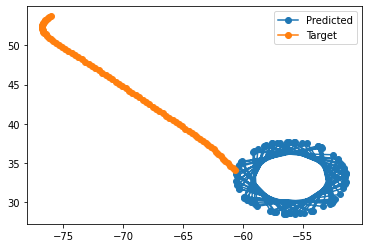

In [21]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:,0].detach().numpy(), target[:,1].detach().numpy(), marker='o', label='Target')
plt.legend()

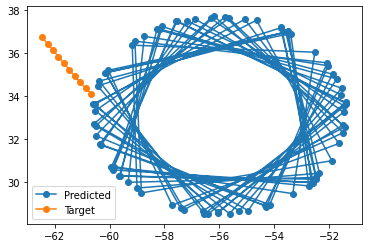

In [22]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:10,0].detach().numpy(), target[:10,1].detach().numpy(), marker='o', label='Target')
plt.legend()

In [23]:
torch.vstack([torch.rand((3,)) for _ in range(10)])

tensor([[0.7774, 0.0306, 0.5629],
        [0.5104, 0.1553, 0.1223],
        [0.7351, 0.5903, 0.3751],
        [0.8642, 0.5919, 0.2521],
        [0.8156, 0.6098, 0.8425],
        [0.3920, 0.4442, 0.8278],
        [0.9444, 0.3471, 0.3953],
        [0.6373, 0.5589, 0.9412],
        [0.2454, 0.3498, 0.8160],
        [0.0415, 0.8656, 0.4123]])

In [24]:
loss = nn.MSELoss()
loss(outp_trace,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32))

tensor(2193.5940, grad_fn=<MseLossBackward0>)

  0%|          | 0/470 [00:00<?, ?it/s]

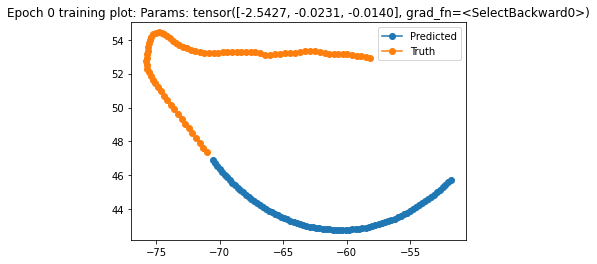

174.3002274005971


  0%|          | 0/118 [00:00<?, ?it/s]

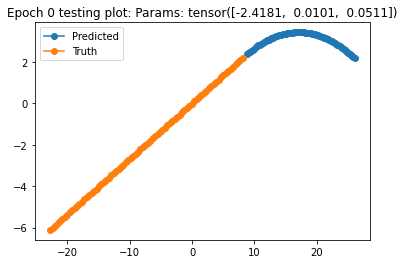

195.7841792834007
Epoch 0 | Train Loss: 174.3002274005971 | Test Loss: 195.7841792834007


  0%|          | 0/470 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
# Training Loop
torch.autograd.set_detect_anomaly(True)
net = LSTMPredictor()
net.to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
train_losses = list()
test_losses = list()

for epoch in range(100):
    cum_train_loss = 0.0
    for input_data, target_data in tqdm(train_dataloader):
        net.zero_grad()
        input_data = input_data.squeeze().to(DEVICE)
        outp = net(input_data)
        outp = outp.squeeze()
        outp = outp.to("cpu")
        target_data = target_data.squeeze()
        #print(outp.shape)
        outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
        loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
        loss.backward()
        optimizer.step()
        cum_train_loss += loss.item()
    plt.title(f"Epoch {epoch} training plot: Params: {outp[-1]}")
    plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
    plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
    plt.legend()
    plt.show()
    cum_train_loss /= len(train_dataset)
    train_losses.append(cum_train_loss)
    print(cum_train_loss)
    cum_test_loss = 0.0
    with torch.no_grad():
        for input_data, target_data in tqdm(test_dataloader):
            input_data = input_data.squeeze().to(DEVICE)
            outp = net(input_data)
            outp = outp.squeeze()
            outp = outp.to("cpu")
            target_data = target_data.squeeze()
            outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
            loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
            cum_test_loss += loss.item()
        plt.title(f"Epoch {epoch} testing plot: Params: {outp[-1]}")
        plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
        plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
        plt.legend()
        plt.show()
    cum_test_loss /= len(test_dataset)
    test_losses.append(cum_test_loss)
    if cum_test_loss <= min(test_losses):
        torch.save(net.state_dict(), "best_simple_bicycle.pt")
    print(cum_test_loss)
    print(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")

In [ ]:
plt.title(f"Learning Curves")
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(test_losses, marker='o', label="Testing Loss")
plt.legend()
plt.show()

In [ ]:
test_losses